In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score 
from sklearn.metrics import r2_score, mean_absolute_error 


import statsmodels.api as sm

/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

As earth scientist we seek to undertand the physical, chemical, and biological processes that shape the natural world. However, often in earth science we face data that varies temporally, varies spatially, and contains substantial amounts of noise due to both instrumentation and the inherent stochasicity of natural phenomenon. 

With increasing climate instability, coastal areas are some of the most at risk environments as we proceed into the future. Here, I focus on marsh sedimentation recorded as *vertical accretion rate (mm/yr)*, which is the process that builds our coastlines, balancing land lose with land gain. Coastal Louisiana is no stranger to this delicate balance of inputs and outputs. However in recent years, Louisiana's sediment budget has been diminshed by upstream damming and the leveeing of the river systems, amplifying land loss across the coast. The saying is the coastal areas in Louisiana lose about an american football field worth of land each **hour**. This makes it imperative to constrain the drivers of vertical accretion so that we can sustainably manage the coast. 

Recent years have seen an explosion in the use of Machine Learning and Artifical Intellgence across disciplines, from computer vision to medicine to engineering. However, it's use in the natural sciences remains limited. Here, we will use a machine learning framework to identify the primary environmental variables related to vertical accretion to inform our interpration of the phenomenon of marsh vertical accretion. 

The data we use was collected from both the Coastal Reference Monitoring System (CRMS) and the Coastal Information Management System (CIMS) websites. I have also added my own remote sensing and GIS variables derived from Google Earth Engine (NDVI, windspeed reanalysis data, and total suspended sediment estimates) and ArcMap (distance to water and rivers). Data downloads and descriptions are available in the links below: 

CRMS: https://www.lacoast.gov/chart/Charting.aspx?laf=crms&tab=2                       
CIMS: https://cims.coastal.louisiana.gov/monitoring-data/ 

Due to the focus of this tutorial being on ML implementation rather than exploratory analysis and data preprocessing, I have done the justice of precompiling the dataset by excluding irrelevant variables, removing outliers, log transforming the distance variabels (which exhibited logarithmic distributions). However, one should note that the preprocessing part of any ML workflow is one of the most important parts of any project and should be conducted with care.

In [2]:
# read in dataset
df = pd.read_csv(r"/Users/etiennechenevert/Documents/fall2022/ESIP_tutorial/ESIP_dataset3.csv", 
                encoding="unicode_escape")
print(df.columns) # lets see what variables we are working with

Index(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)',
       'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)',
       'Log Distance to Water (km)', 'Log Distance to River (km)',
       'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)',
       '10th Percentile Flood Depth (cm)', 'Std. Deviation Flood Depth (cm)',
       'Avg. Flood Depth (cm)', 'Community', 'Longitude', 'Latitude',
       'Organic Matter (%)', 'Bulk Density (g/cm3)'],
      dtype='object')


In [78]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns) )

Number of samples in dataset:  208
Number of features in the dataset:  21


In [3]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Longitude', 'Latitude', 'Bulk Density (g/cm3)', 'Organic Matter (%)'
], axis=1)

I removed the variables: longitude, latitude, bulk density (g/cm3), and organic matter (%) because they do not provide us with an associated transport or biologic process such as flooding, biomass production, biomass decay, erosion, etc. Latitude and longitude are only geographic descriptions of where sites are, making them uninformative towards a process understanding of vertical accretion. While bulk density and organic matter (%) are descriptions of the soil that has already been deposited, rather than *how* it might have been deposited.

In [4]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; excluding the categorical Site and Maarsh community variables
print(feature_ls) # looks good; great!

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)', 'Log Distance to Water (km)', 'Log Distance to River (km)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Std. Deviation Flood Depth (cm)', 'Avg. Flood Depth (cm)']


## Data Description

The remaining variables that will be used in the analysis are: 
* **Accretion Rate (mm/yr)**: The amount of sediment deposited above a datum. Recorded with a 6 to 18 month sampling period.
* **Soil Porewater Salinity (ppt)**: The ppt measured from a syringe inserted into the soil. Recorded variably to annually.
* **Average Height Dominant (cm)**: Survey measurement of the average hieght of the dominant vegetation species. Sampled annually. 
* **NDVI**: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7. Samples consisted of an 8 day averages only collected during the months of peak biomass, July-August.
* **TSS (mg/l)**: Estimate of Total Suspended Sediment (TSS) from MODIS. With a 2-day sampling (recurrance) interval.
* **Windspeed**: Reanalysis data from the Global Wind Atlas availible from Google Earth Engine (GEE).
* **Tidal Amplitude (cm)**: The average daily difference between the highest recorded and lowest hourly waterlevel.
* **Average Time Flooded (%)**: The percentage of time in which the waterlevel exceeds the elevaation of the marsh. Calculated from hourly waterlevel measurements.
* **Flood Frequency (Floods/yr)**: The number of times that the waterlevel exceeds the elevation of the marsh. Calculated from hourly waterlevel measurements.
* **Average Flood Depth (cm)**: The average waterlevel when the waterlevel is higher than the marsh elevation. Calcualted from hourly waterlevel measurements. 
* **90th Percentile Flood Depth (cm)**: The 90th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements.
* **10th Percentile Flood Depth (cm)**: The 10th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements.
* **Std. Deviation Flood Depth (cm)**: The standard deviation of the timeseries distribution of average flood depth. Calcualted from hourly waterlevel measurements. 
* **Log Distance to Water (km)**: The log of the distance to the nearest water pixel (90% recurrence). 
* **Log Distance to River (km)**: The log of the distance to the nearest GRWL river vector taken from GEE. 
* **Community**: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

Note that all of these variables spanned either the lifespan of a CRMS site which largely encapsulates 2007 to 2022. 

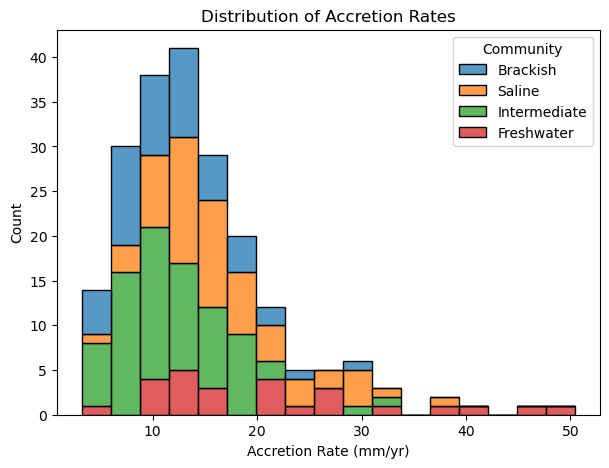

In [5]:
# Lets visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [6]:
# lets define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [7]:
target.describe()

count    208.000000
mean      14.544686
std        7.679710
min        3.208008
25%        9.684788
50%       12.701547
75%       18.200853
max       50.425133
Name: Accretion Rate (mm/yr), dtype: float64

In [8]:
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),Windspeed (m/s),Avg. Time Flooded (%),Flood Freq (Floods/yr),Log Distance to Water (km),Log Distance to River (km),Tidal Amplitude (cm),90th Percentile Flood Depth (cm),10th Percentile Flood Depth (cm),Std. Deviation Flood Depth (cm),Avg. Flood Depth (cm)
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,7.488726,109.645313,0.345306,33.776169,6.714686,42.729742,163.631107,0.166635,2.974625,11.507986,29.304439,0.657840,13.493443,12.320192
std,5.919844,21.135709,0.108436,10.845693,0.248734,24.813103,109.303101,1.027612,1.067866,9.183479,9.156496,2.155759,2.801808,6.099182
min,0.200000,54.860000,0.099034,0.000000,5.989133,0.000000,0.000000,-3.534766,-1.828729,0.060442,8.424672,0.000000,5.361793,2.454536
25%,2.500000,96.770000,0.282428,28.675858,6.548332,25.715094,63.564421,-0.223163,2.451048,1.866514,23.483316,0.000000,11.373617,7.890813
50%,5.800000,106.800000,0.350556,32.980339,6.742525,45.308426,163.274714,0.000000,3.259573,11.038231,29.001720,0.000000,13.288951,11.037287
75%,12.000000,120.700000,0.388779,40.282164,6.890631,59.509360,249.619152,0.947898,3.808251,20.102054,34.839402,0.000000,15.571800,15.539290
max,24.500000,190.800000,0.627081,58.441428,7.315856,99.965846,534.000000,2.084955,4.305684,27.500165,56.144160,14.782800,20.273093,30.990717


# Bayesian Linear Regression

Below I will implement a Bayesian Linear Regression (BLR) model, which is one of the most interpretable machine learning models for regression one can use. It is a paramteric machine learning model which means that we assume the functional form of our model, which we assume to be linear for BLR. We do this for a few reasons, (1) to establish a baseline model performance, (2) a Bayesian treatment of linear regression results in instrinsic uncertainty metrics that can be interpreted, and (3) to be able to understand how the model makes decisions without any post-training analyses. 

Scikit learn provides many machine learning models, including a ready to implement BLR model that we will use for this tutorial. I have to admit, I am fond of the BLR and find the mathematical intuition behind it to be **awesome**. So, if you share my euthusiasim for BLR and want to learn more, I would suggest checking out this blog post that walks through the derivation and intutition behind the model: https://pourmand1376.medium.com/bayesian-linear-regression-full-derivation-from-scratch-6e0bc2c9c4ab. 

Another great source for the self study of machine learning models is the textbook *Pattern Recognition and Machine Learning* by Christopher Bishop, which has been extremely enlightening to me.

However, I will skip the more complicated mathematics and focus on the machine learning workflow that can get you started on your on projects!

In [9]:
# Lets begin the implementation
# First, we need to scale the predictors in order to extract relative feature importances. Additionlly, 
# interpretation of variable weights are easier when the predictors are mean centerd (mean = 0).
scalar_Xwhole = StandardScaler()
predictors = pd.DataFrame(scalar_Xwhole.fit_transform(phi), columns=phi.columns.values)

In [10]:
# Now lets make a simple function that can invert the weight scales. This is important for when we want to interpret
# the weight coeffiencents in the classic sense of "a one unit increase in X will result in a ... increase/decrease in
# y."

def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression
    https://stackoverflow.com/questions/57513372/can-i-inverse-transform-the-intercept-and-coefficients-of-
    lasso-regression-after
    Better source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean())))  # hadamard product

    return coefs_new, intercept

## Feature Selection

Feature selection is the process of removing variables that do not add predictive power to the model. This decreases the models complexity and makes interpretation more straight forward. In a linear regression model, too many variables can lead to overfitting as well, so it is good practice to only choose variables that are essential in capturing the relationship we want. Although the Bayesian Ridge Regression has a L2 regularization term, which mitigates overfitting, there is only so much this term can do to reduce overfitting because of redundant features. Therefore, let's employ a simple feature selection algorithm called *backward feature elimination* to get only the significant features associated with vertical accretion rate.

My backward feature elimination algorithm fits a ordinary least squares (OLS) regression to all the data, calculates the p-value of every predictor variable, removes the predictor with the highest p-value from the dataset, then repeats until all predictors are significant based on a p-value less than 0.05 (or any given significant threshold). 

In [11]:
def backward_elimination(data, target, num_feats=10, significance_threshold=0.05):
    """
    data: dataframe of predictors
    target: dataframe of target variable
    num_feats: maximum number of features to be included in the return list
    significance_threshold: threshold p-value that determines significance and elimination
    
    returns: list of significant variables
    
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_threshold) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features


bestfeatures = backward_elimination(data=predictors, target=target, num_feats=10, significance_threshold=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'NDVI', 'TSS (mg/l)', 'Avg. Time Flooded (%)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)']


Great! We have found the most significant variables with lienar relationships associated with vertical accretion. Let's now make a new set of predictors consisting of only the significant variables and initilize the BLR model.

In [12]:
# Lets use these selected features to define our ML dataset
X, y = predictors[bestfeatures], target
# initialize scikit learn's model
baymod = linear_model.BayesianRidge(fit_intercept=True)

## Model Performance Evaluation and Cross Validation

In order to assess the performance of our model, we need to test it on *unseen* data, data that it has not been trained on. The simplest way to do this is to split the dataset into two parts, a train set and a test set. A model is fit to the training set, then given the predictors of the test set, we produce estimated values for our target, which we then quantify the error between our estimations and measured values to determine how accurately our model performs. 

The train-test approach will only accurately capture the full variability of the dataset if our dataset is large enough that the test set mirrors the distribution of the train set. Unfortunately, in small dataset applications, we often can not confidently assume this. Therefore, it is important train and test of a model on different subsets of the dataset, this approach is called cross validation. 

To conduct cross validation, we need to split the dataset into 𝐾 number of folds. We then train the model on  𝑘−1  folds, then test on the fold left out. We then repeat the process 𝐾 times, alternating the fold we test on, and then we average the results. This is called *K-fold cross validation*.

Another similar method for evaluating the general model perforamnce is called *Repeated K-fold Cross Validation*. The only difference of repeated K-fold cross validation is that we average the results of the K-folds, then repeat the procedure again with a different set of K-folds, then average those results to get a final performance metric. This can repeat as many times as the user wants, but generally after 50 or 100 repeats we have trained and tested the full variability of the dataset.

In the below implementation I write code to do 100 times repeated 5-fold cross validation, which effectively trains 500 models. I save the results and learned parameters of these models and report the range and averages of them. This gives us a robust sense of what the model is learning and how it is performing.

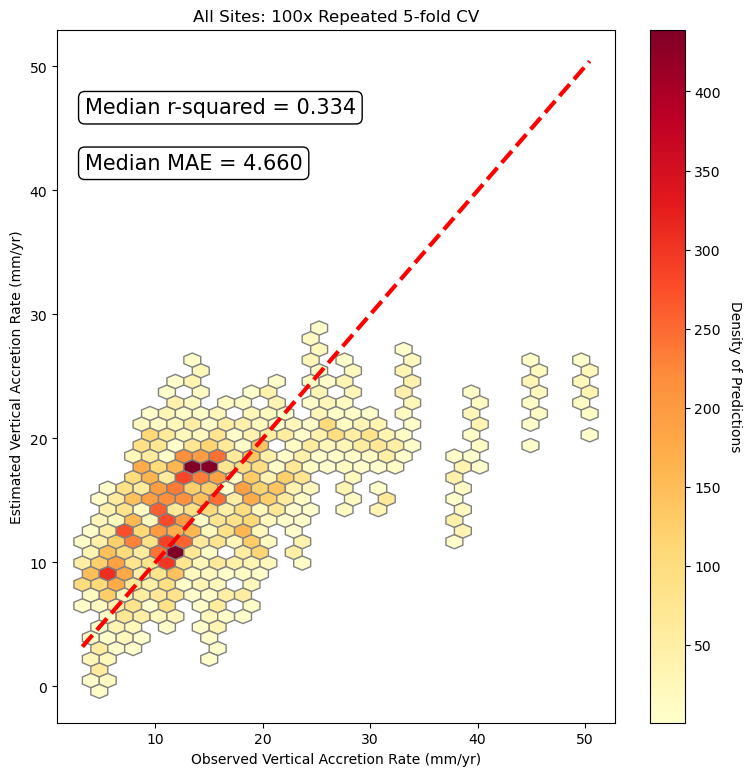

['Scaled Weights', 'Unscaled Weights', 'Unscaled Intercepts', 'Scaled regularizors', '# Well Determined Weights', 'Standard Deviations of Predictions', 'Predictions', 'Residuals', 'Predicted for Residuals']


In [13]:
def cv_results_and_plot(unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):

    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y
    residuals = []

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_weight_certainty = {}  # holds our estimate of the number of "well-determined" parameters
    hold_intercept = {}  # holds the intercepts found
    hold_prediction_certainty = {}  # holds the std deviations of the predictive distributions
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    intercept_ls = []  # holds the inverted intercept to its natural scale
    weight_certainty_ls = []  # holds the number of well-determinned parameters for each k-fold test
    prediction_certainty_ls = []  # holds the standard deviations of the predictions (predictive distributions)
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_certain = []
        pred_list = []
        w_certain = []

        for train_index, test_index in try_cv.split(X):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[bestfeatures],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

            intercept_ls.append(intercept)
            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))
            weight_certainty = []
            for eig in eigs[0]:
                weight_certainty.append(eig/(eig + baymod.lambda_))
            weight_certainty = np.sum(weight_certainty)
            w_certain.append(weight_certainty)
            # Make our predictions for y
            ypred, ystd = baymod.predict(X_test, return_std=True)
            # Save average std on each prediction
            # pred_certain.append(np.mean(ystd))

            pred_list += list(ypred)
            pred_certain += list(ystd)


            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_certainty_ls.append(pred_certain)
        prediction_list.append(pred_list)

        weight_certainty_ls.append(np.mean(w_certain))
        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
        residuals = residuals + list(target.values.ravel() - cross_val_predict(baymod, predictor_matrix, 
                                                                          target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=bestfeatures)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=bestfeatures)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)
    
    # Below code is for the figure
    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Observed Vertical Accretion Rate (mm/yr)")
    ax.set_ylabel("Estimated Vertical Accretion Rate (mm/yr)")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, "Unscaled Weights": unscaled_weight_df, "Unscaled Intercepts": intercept_ls, 
        "Scaled regularizors": regularizor_ls, "# Well Determined Weights": weight_certainty_ls, 
        "Standard Deviations of Predictions": prediction_certainty_ls, "Predictions": prediction_list, 
        "Residuals": residuals, "Predicted for Residuals": predicted
    }


results_dict = cv_results_and_plot(phi, X, y, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(list(results_dict.keys()))

We see that we get a predictive accuracy of about ~30% R-squared and a mean absolute error of about ~4.6 millimeters (slight fluctuations will happen with each run due to the randomness of the K-fold splitting). This model is less than ideal because, since vertical accretion is a natural phenomenon governed by natural laws of chemistry, biology, and physics, we should expect a higher predictive accuracy. 

Note that our model consistently underpredicts for higher vertical accretion rates. As depositional rates increase, the variability in accretion rates also increases which reduces the capability of our model to learn the proper relationship of the data. A future investigation could be aimed at constraining which variables are associated with this variability and investigating what events influence the variabiloty in accretion rates.

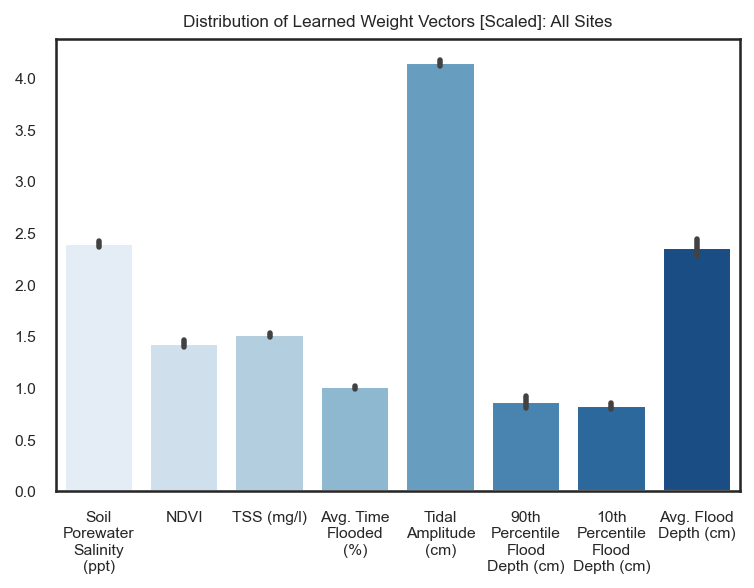

In [14]:
def wrap_labels(ax, width, break_long_words=False):
    """ This function is only for the visualization of plots
    
    ax: plot axis object 
    width: width of textwrap
    break_long_words: boolean as to break long words in wrapping or not
    
    directly from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

The bar chart above indicates the relative feature importances of the identified variables. Of the identified salient variables from the dataset related to accretion, we see that tidal amplitude is the most important variable contributing to accretion in our linear model, while suspended sediment concetration is the least important variable contributing to accretion in the model. However, be sure to note that suspended sediment is still a significant variable defined by the backward elimination algorithm.

Something to consider here is the multicollinearity between the variables that is inherent to these environments. We must acknowledge that this potential bias may affect any future interpretations of the model. Additionally, the feature importances of each variable will vary depending on which type of model they are fit to. 

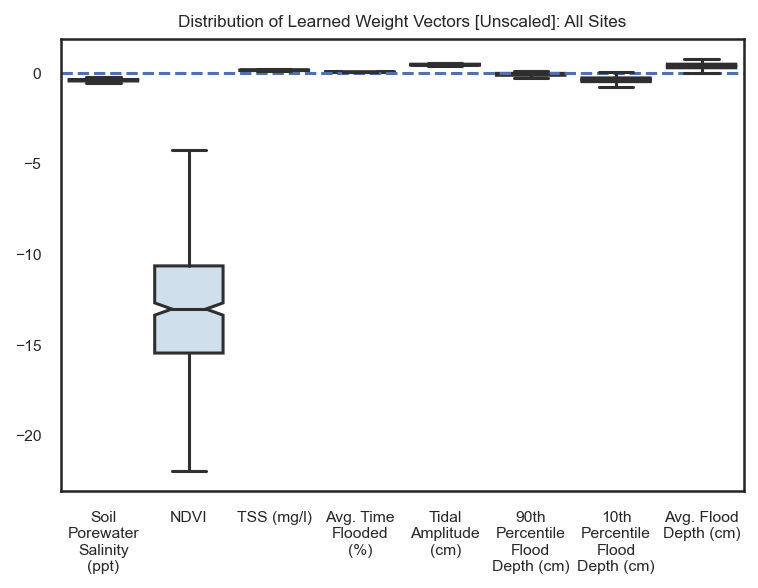

Soil Porewater Salinity (ppt)       -0.407121
NDVI                               -13.034492
TSS (mg/l)                           0.140521
Avg. Time Flooded (%)                0.040375
Tidal Amplitude (cm)                 0.453714
90th Percentile Flood Depth (cm)    -0.080284
10th Percentile Flood Depth (cm)    -0.380679
Avg. Flood Depth (cm)                0.385024
dtype: float64

In [16]:
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict["Unscaled Weights"].median()

The above plot is now the unscaled weight coefficents. They are representaed through a boxplot because, since we run a 5-fold 100x repeated cross validation scheme, we train 500 models with slightly different learned weights because of slightly different splits of the data. Therefore, it is important to show the full range of the learned weights. We can intepret these as one would usually for any ordinary least squares regression such as "a one centimeter increase in tidal amplitude results in a ~0.45 mm/yr increase in the vertical accretion rate at a CRMS station."

These weight coeffiecents give us both the magnitude and direction of change. An increase in soil porewater salinity, NDVI, 90th percentile flood depth, and 10th percentile flood depth all negatively influence our models estimated accretion rate. While TSS, tidal amplitude, average percent time flooded, and flood depth all positively influence estimated deposition rates.

## Gaussian Process Regression

Although linear models are great first order approximations, most of earth processes display nonlinear relationships. So, in many occasions a linear fit can be a silly approximation. As a natural step forward from BLR, let's try a non-parametric model that can capture nonlinear relationships and interactions: a Gaussian Process regression (GPR) model. Engrained in Bayesian methods, the GPR model is a kernel based machine learning model that models variable interactions through a kernel matrix that is defined by the user. This kernel matrix essentially computes how similar to variables are. Here, we use an exponentiated dot product kernel that will create quadratic relationships between our predictors and our outcome variable. The main equations defining a gaussian process correspond to:

$$ 
\begin{aligned}
y|f(x) \sim \mathcal{N}(f(x), \sigma^2 I) \\
f(x) \sim \mathcal{N}(0, K) \\
\epsilon \sim \mathcal{N}(0, \sigma^2) \\
\end{aligned}
$$

$y$ is the target variable we want to approximate with some function $f(x)$ that comes from a normal distribution of an infinte number of functions with a $0$ mean and variance of $K$ and a noise term from the data that is normally distributed with a $0$ mean and variance of $\sigma^2$. With this in mind, the distribution of our expected outcome would follow the distribution of:

$$y \sim \mathcal{N}(0, K + \sigma^2 I)$$

Then to find the distribution of potential functions given our data, we can calculate the posterior distribution of the function $f(x)$ given the training target values. This equation comes from rules regarding the conditional probability of partitioned gaussians:

$$ f(x) | y \sim \mathcal{N}(K(K + \sigma^2 I)^{-1} y , K - K (K + \sigma^2 I)^{-1} K) $$

Now, we want to know the posterior predictive distribution for the best function that approximates both the training and the testing data, again follow the rules for the conditional probability of partitioned gaussians to get:

$$ 
\begin{aligned}
f(x^*)| y \sim \mathcal{N}(\bar{f(x)}, \bar{V}) \\
\bar{f(x)} = K(x^*, x) (K(x, x) + \sigma^2 I)^{-1} y \\
\bar{V} = K(x^* , x^*) - K(x^*, x) K(x^*, x) (K(x, x) + \sigma^2 I)^{-1} K(x, x^*) \\
\end{aligned}
$$

Using scikit-learn again to implementing a GPR model, we will extract less information directly from the trained models than we did for the BLR. Rather, we will use a post hoc machine learning interpretability package called *SHAP* to interpret how our model makes predictions with the inputted variables.

Rather then restarting the feature selection process from scratch, we will use the same identified variables as before. Again, we have to acknowledge the potential bias in these due to both multicollinearity and selection via the p-value which is meant for linear relationships, not nonlinear correlations. However, we hope our model is able to capture interactions between variables that the linear model will not.

As you can see above, the conditional probability of the target variable is analytically tractable and has some fun math in its derivation. I do not go through the derivation and logic fully in this tutorial because I want to focus more on the machine learning workflow and its application to scientific discovery. However, a great explanation of the derivation is available online here: https://towardsdatascience.com/gaussian-process-regression-from-first-principles-833f4aa5f842. Or in the *Pattern Recognition and Machine Learning* textbook by Christopher Bishop

In [20]:
# Load packages relevant for the gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern

# Derived from https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
kernel = (DotProduct()**2) + WhiteKernel()

# GP model 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1, normalize_y=False, random_state=123)

rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
# scores = cross_val_score(rs_model.best_estimator_, predictors, target.values.ravel(), scoring='r2',
#                          cv=rcv, n_jobs=-1)
scores = cross_validate(gp, X, y, cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median GP R^2 score", np.median(scores['test_r2']))
print("Median GP MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median GP R^2 score 0.42930746368087974
Median GP MAE score 4.244386833409534


## SHAP Analysis

SHapley Additive exPlanations, SHAP, is a python package to explain how your model makes predictions after training. This is called *post hoc interpretability* by Roscher et al 2020. The package is easy to install and use on a variety of different models.

The idea of using SHAP values for machine learning explainability comes from cooperative game theory. Where each sample of data acts like a player in a game, that can be marked as "present" in the game or "absent" in the game. The computation of SHAP values can be very difficult and complicated, but they have a simple interpretation. The SHAP value is essentially able to quantify each sample's contribution to the expected target variable. Allowing us to see how this variables across samples as well as acress feature vectors.

The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

I am only going to do a SHAP analysis on the Gaussian Process model because we have already assessed the relative feature importances of the Bayesian Ridge model through the scaled weight coefficents. However, there is no simple analogous interpretation of the parameters of the scikit learn Gaussian Process regression model. There, the SHAP post-hoc explainiability method must be employed to gain insight into how our model makes decisions.

<class 'pandas.core.frame.DataFrame'>


Exact explainer: 209it [00:11,  1.97it/s]                                       


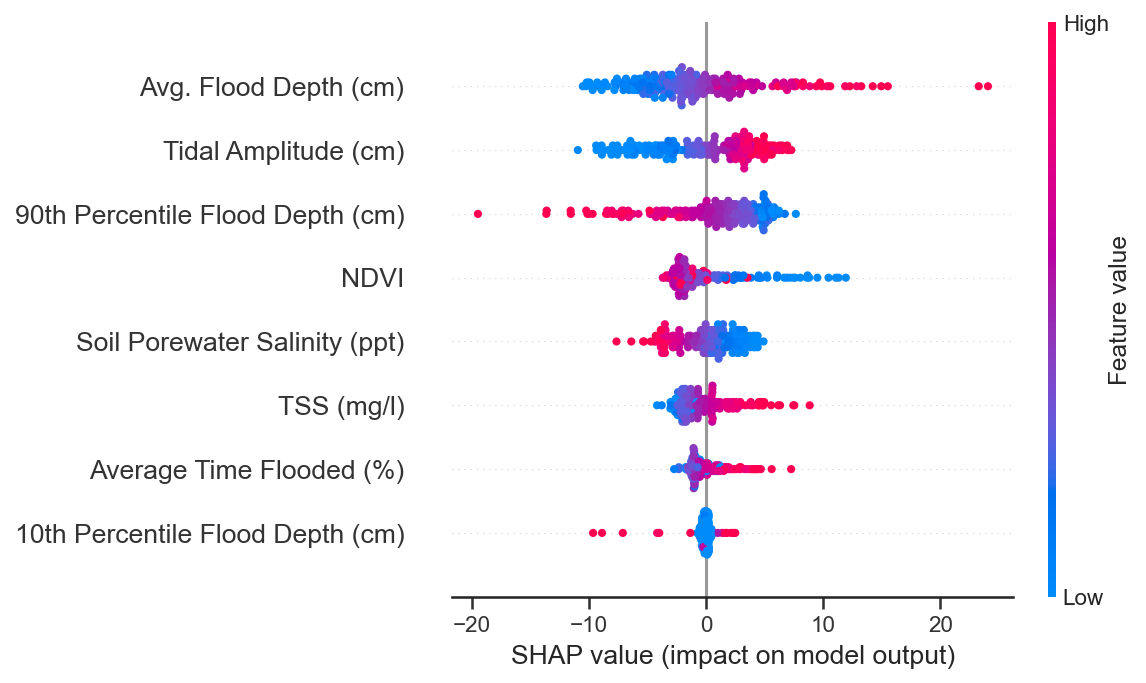

In [113]:
# fit the model first
gp.fit(X, y)
# Shap Analysis
X500 = shap.utils.sample(X, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(gp.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(X)

# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.summary_plot(shap_values_ebm, features=X, feature_names=X.columns)

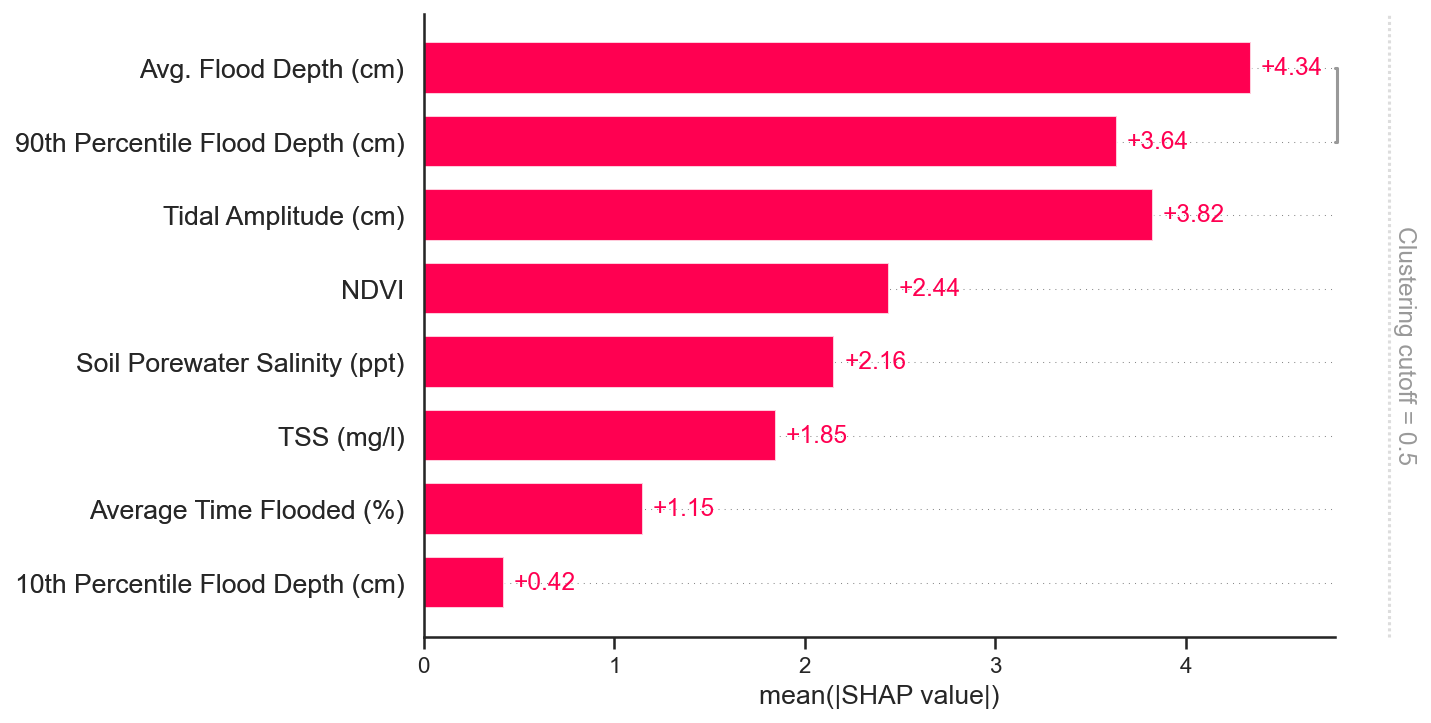

In [94]:
clustering = shap.utils.hclust(X, y)
shap.plots.bar(shap_values_ebm, clustering=clustering)

Something to note before proceeding is that these dependence plots show the influence of a certain variable from the GPR model on the SHAP value. As mentioned above, the SHAP value is a proxy for how the model influences our target variable, accretion rate. Therefore, I will be refering to an increase in the SHAP value as an increase in the expected accretion rate in my following interpretations.

The summary beeswarm and clustering plots can give us a brief overview of some of the salient relationships within the GPR model. For instance, average flood depth, tidal amplitude, TSS, and average percent time flooded all generally have positive influences on the predicted accretion rate, which corresponds to the findings in the BLR model weights. However, more of the samples in the average flood depth, TSS, and average percent time flooded variables have weakly negatively contribute to predicted accretion. We can discern this be the inspecting the size of the "beeswarm", or density of points, and whether they reside to the left or right of SHAP value = 0. On the other hand, the 90th percentile flood depth, soil porewater salinity, and NDVI generally have a negative relationship with estimated accretion rate. However, the majority of the data in the 90th percentile flood depth and salinity variables contributes weakly positively to expected accretion rate.

The combined importance and clustering plot indicates that there is a significant correlation between the average flood depth and the 90th percentile flood depth, which is expected. Their relationship most then be taken into account when interpreting the relative importance of 90th percentile flood depth and average flood depth, as one of the variables may be redundant and its importance exaggerated. 

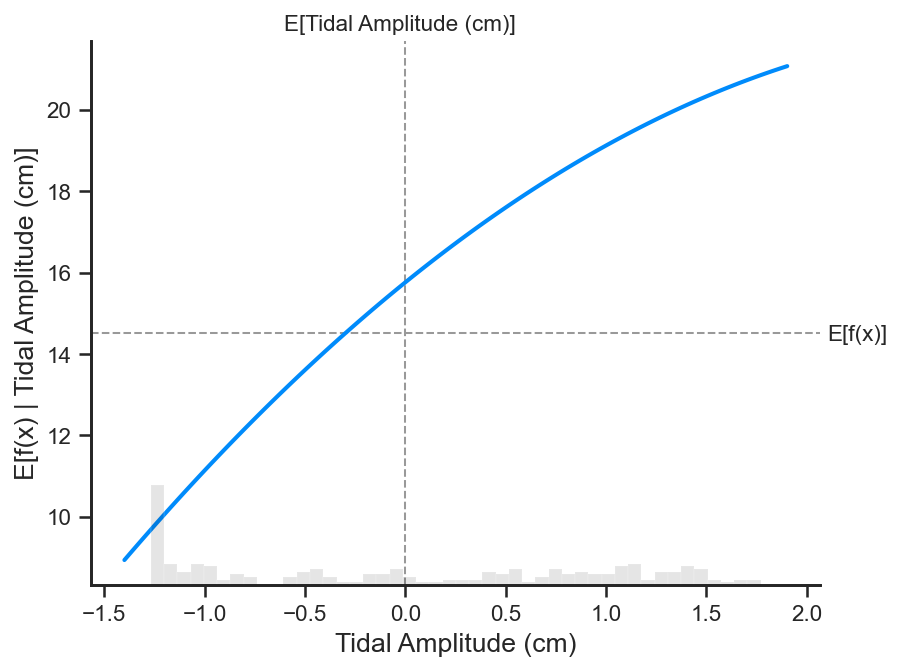

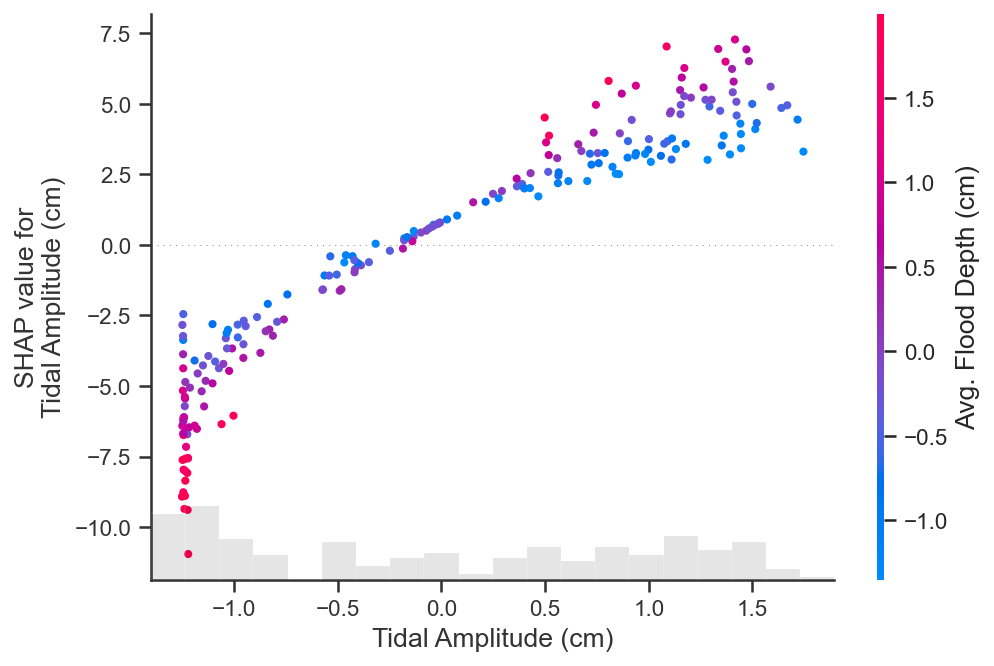

In [99]:
shap.partial_dependence_plot(
    'Tidal Amplitude (cm)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Tidal Amplitude (cm)"],
                   color=shap_values_ebm[:,"Avg. Flood Depth (cm)"])

The zero in the x-axis indicates that mean of the tidal amplitude data distribution, while each unit is in standard deviations. We notice that across the mean of the tidal amplitude data, standard deviations = 0.0, flood depths have a opposite association with tidal amplitude and accretion rate. Where tidal amplitudes are below the mean, flood depth decreases with increasing tidal amplitude, while the expected accretion rate increases. Where tidal amplitudes are above the mean, flood depths increase with increasing tidal amplitude, while the expected accretion rate also increases.

The relationship here really highlights the dominance of the tidal amplitude, or the relative position of a CRMS station in the tidal frame, as a predictive variable for accretion rate. Additionally, with tidal amplitude increasing with flood depth above the mean tidal amplitude, we may expect this to be due to a greater influence of oceanic flood waters on flooding. 

To test qualitatively test this, we can look at the relationship between tidal amplitude, flood depth, and soil porewater salinity, assuming that an increase in the soil porewater salinity is associated with a more saline flooding regime.

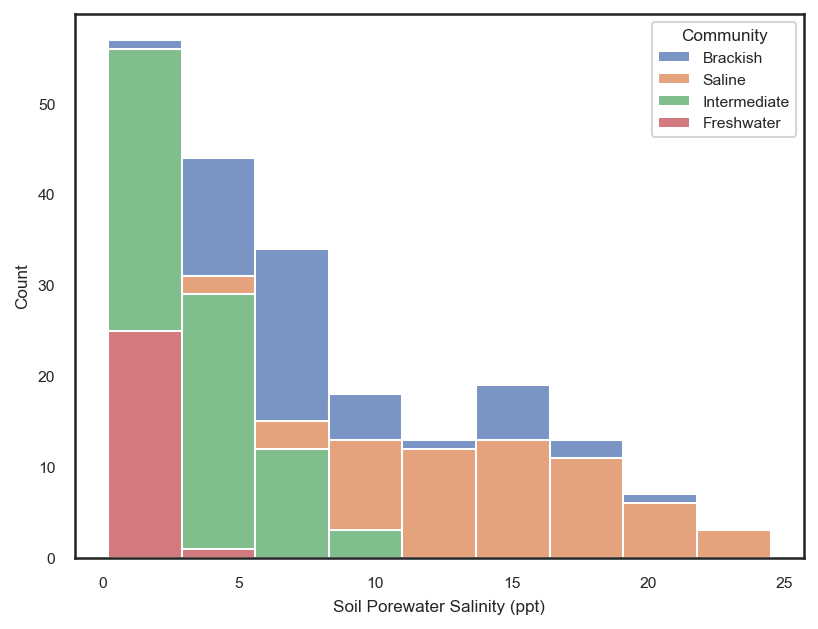

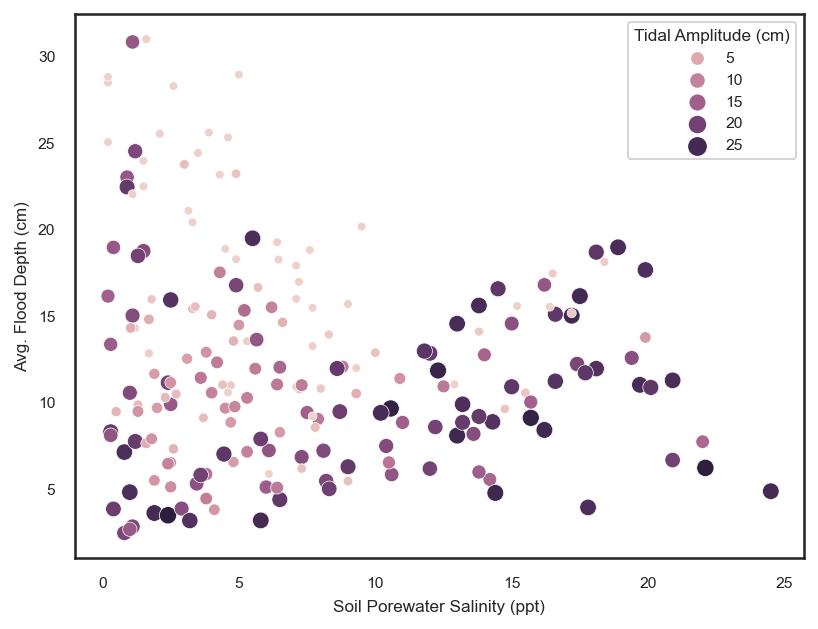

In [100]:
# Histogram to see splits in salinity distributions across marsh types
sns.histplot(data=df, x='Soil Porewater Salinity (ppt)', hue='Community', multiple='stack')
plt.show()
# scatter
sns.scatterplot(data=df, x='Soil Porewater Salinity (ppt)', y='Avg. Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

The stacked histogram shows us that the distribution of salinity values in the saline marsh sites deviate from the fresher water sites around a value of ~10 ppt. By examining the subsequent scatter plot, we see that above salinity values of ~10 ppt, in the saline marshes, there is a positive trend between salinity and flood depth. While, for salinity values less than ~10 ppt, there is no relationship to a weak logarithmic relationship between flood depth and salinity. This could be potentially highlighting the difference in flooding regimes between the saline sites and the fresher water sites. Where in the saline marshes, floods predominately originate from the ocean, bringing with them more saline water to the marshes. While in the fresher waters, flood waters are more variable to dominantly freshwater floods originating from the nearby rivers and bayous or terrestrial hydrologic regime.

In [21]:
# partial dependence plot for average flood depth
shap.partial_dependence_plot(
    'Avg. Flood Depth (cm)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now, lets also check out the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "Avg. Flood Depth (cm)"], 
                   color=shap_values_ebm[:,"90th Percentile Flood Depth (cm)"])
# partial dependence plot for 90th percentile flood depth
shap.partial_dependence_plot(
    '90th Percentile Flood Depth (cm)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now lets look at the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "90th Percentile Flood Depth (cm)"], 
                   color=shap_values_ebm[:,"Avg. Flood Depth (cm)"])

NameError: name 'X500' is not defined

It is interesting that the 90th percentile flood depth feature displays a concave, largely negative function with expected accretion rate. Looking at the interaction between the 90th percentile flood depth and the average flood depth, we see that as average flood depth increases, so does the 90th Percentile of flood depth as expected. The interaction between these two variables indicates that our model seems to use the large end members of the floods, 90th percentile floods, to provide a "check" on accretion rates, not allowing accretion rates to become excessive.

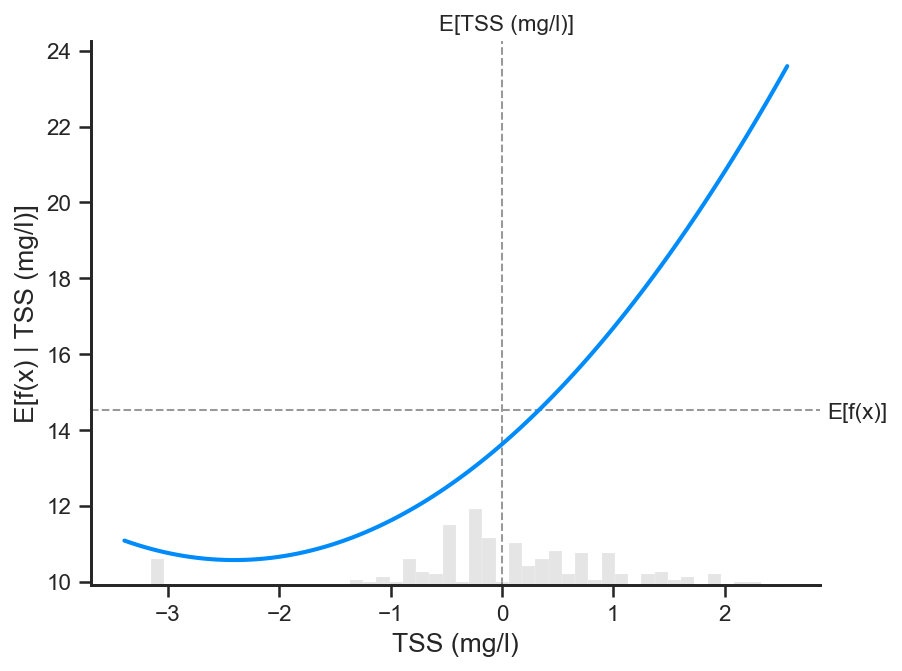

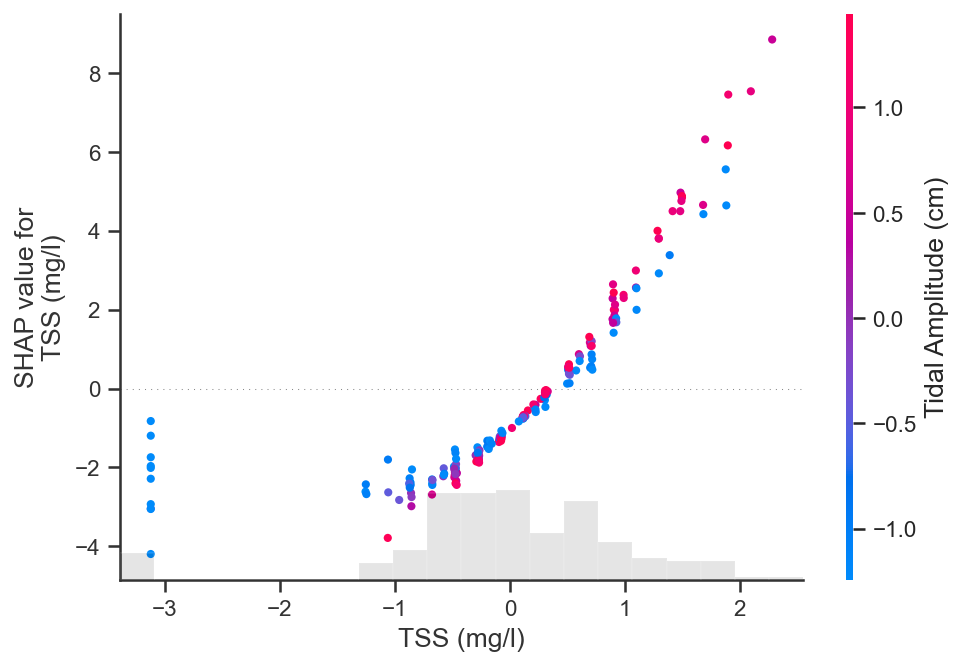

In [103]:
shap.partial_dependence_plot(
    'TSS (mg/l)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "TSS (mg/l)"],
                   color=shap_values_ebm[:,"Tidal Amplitude (cm)"])

It can be seen that CRMS stations with both low and high tidal amplitudes have an increase in the predicted accretion rate as the estimated total suspended sediment concentration increases exponentially. This relationship makes ense as more available sediment inthe nearby waters likely is positively proportional to how much seidment is being delived to the nearby marshes.

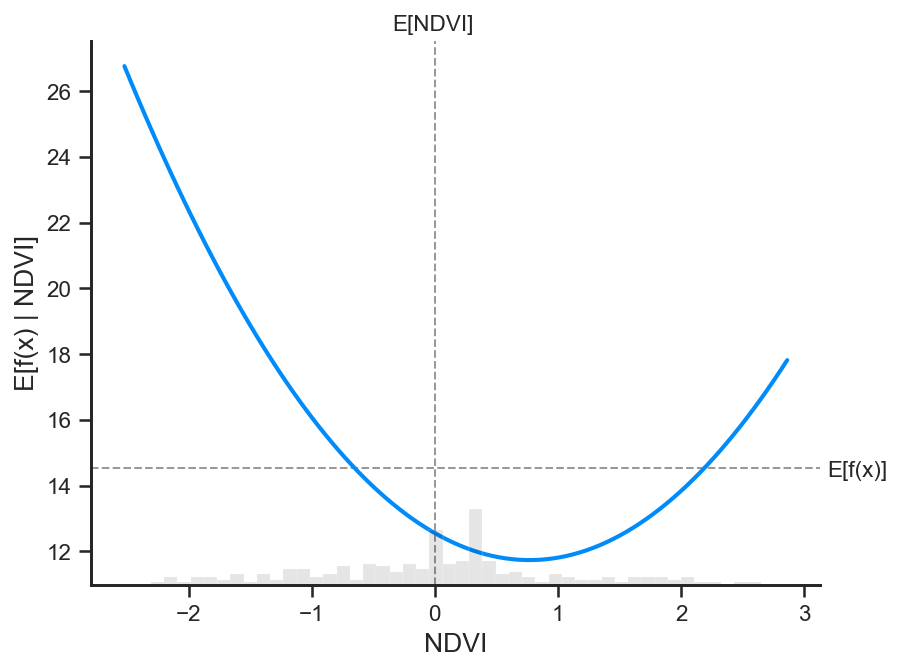

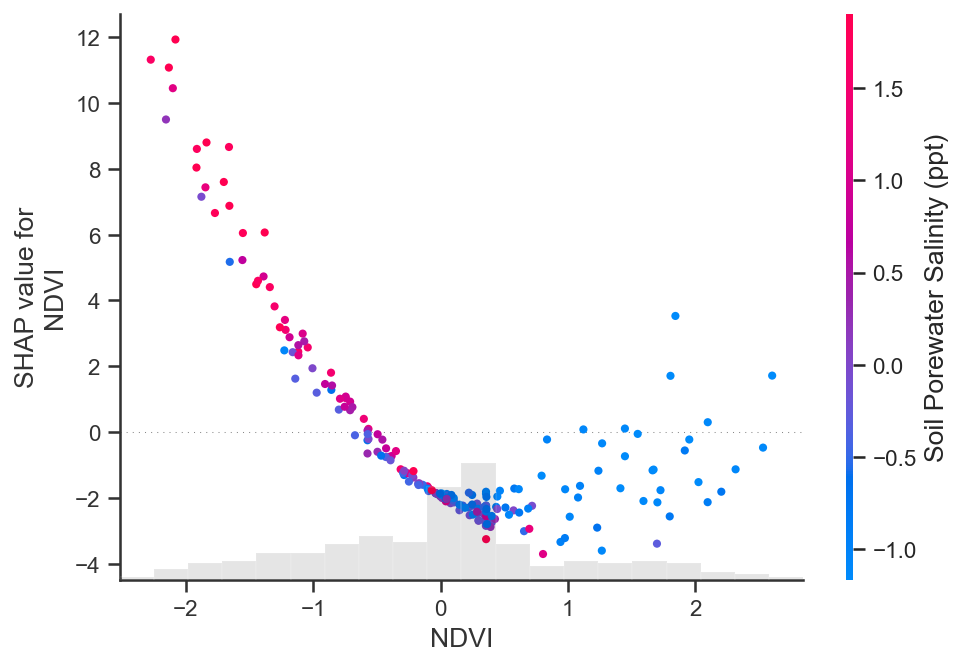

<AxesSubplot:xlabel='NDVI', ylabel='Accretion Rate (mm/yr)'>

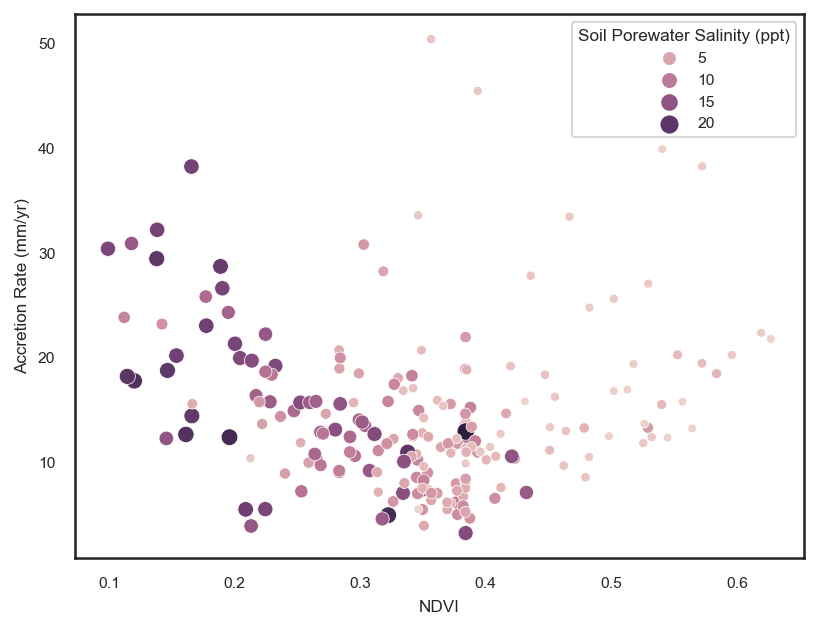

In [104]:
shap.partial_dependence_plot(
    'NDVI', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "NDVI"],
                   color=shap_values_ebm[:,"Soil Porewater Salinity (ppt)"])
# complementary scatter plot
sns.scatterplot(data=df, x='NDVI', y='Accretion Rate (mm/yr)', hue="Soil Porewater Salinity (ppt)", 
               size="Soil Porewater Salinity (ppt)")

The convex function that NDVI has with the expected accretion rate is quite intriguing. The dependence with the the salinity variable indicates that higher salinities are associated with lower NDVI values, but higher expected accretion rates. While, higher NDVI values are associated with lower salinity and lower accretion rates. It is not immediately clear to me why this relationship exists, so let's visit a histogram and scatter plot below to try to disentangle these relationships.

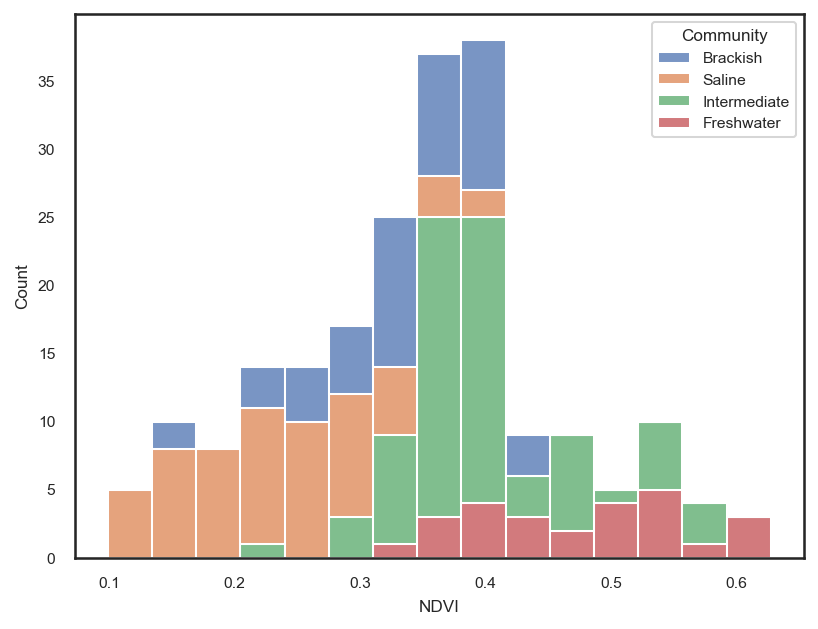

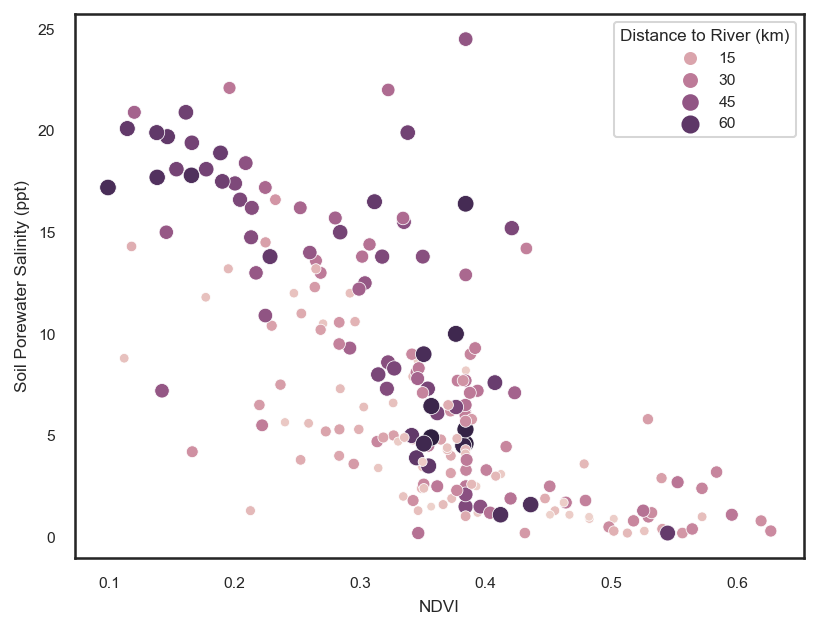

In [105]:
sns.histplot(data=df, x='NDVI', hue='Community',multiple='stack')
plt.show()
# # salinity , tides, and NDVI
# sns.scatterplot(data=df, 
#                 y='Soil Porewater Salinity (ppt)', hue='Tide Amp (ft)', size='Tide Amp (ft)',x='NDVI')
# plt.show()
# salinity, distance to river, and NDVI
df['Distance to River (km)'] = np.exp(df['Log Distance to River (km)'])
sns.scatterplot(data=df, 
                y='Soil Porewater Salinity (ppt)', hue='Distance to River (km)', size='Distance to River (km)', x='NDVI')
plt.show()

The above histogram indicates a split in the NDVI values between the more saline marshes and the more fresh marshes around an normalized NDVI value of ~0.35. 

The first scatter plot replaces the color and size variable with the distance to a major river (width > 30 m). As NDVI increases from 0 to its maximum value, we see the distance from the river variable decrease, increase, then decrease again. This increase occurs sharply at the saline and fresh water marsh NDVI transtion zone. First reading the left side of the scatter plot, NDVI < 0.35, we find that NDVI is greater for sites closer to major rivers. The same is true for the right side of the scatter plot, NDVI > 0.35, where NDVI increases closer to the major river with the exception of a few sites that may be located directly at the mouth of Mississippi River, which is often flooded near the ocean. This makes some intuitive sense, but is fascinating that we can capture it occurring twice, once in the saline marshes then once in the freshwater marshes!

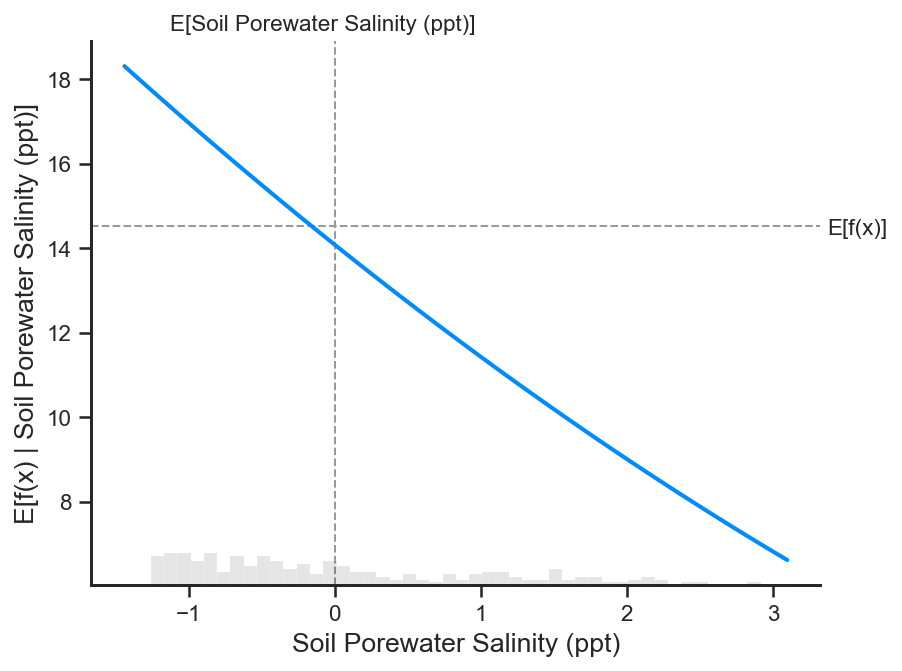

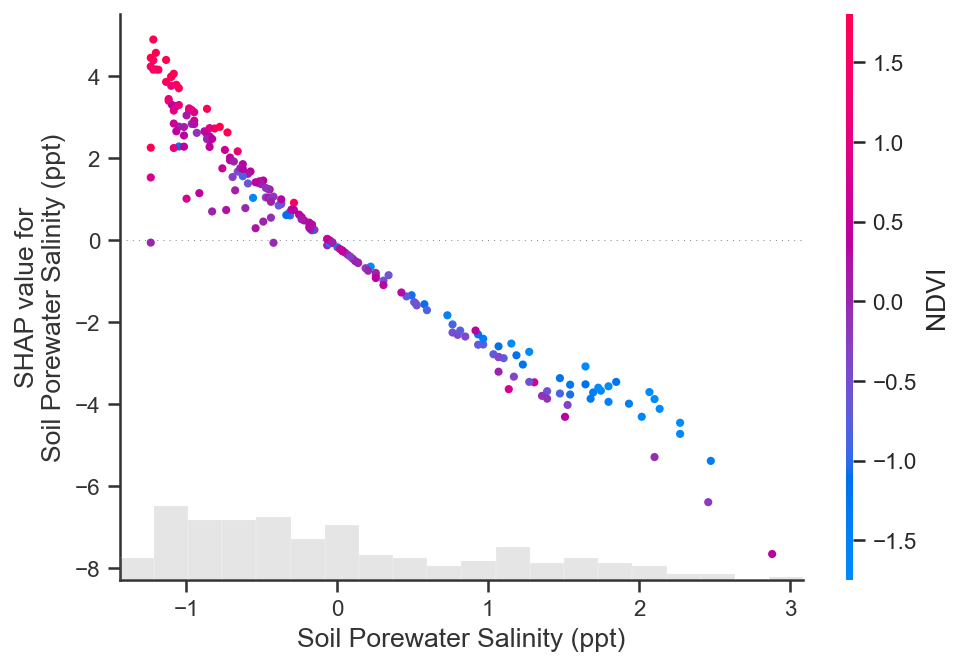

In [106]:
# Let's Look at Salinity Now
shap.partial_dependence_plot(
    'Soil Porewater Salinity (ppt)', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Soil Porewater Salinity (ppt)"],
                   color=shap_values_ebm[:,"NDVI"])

The idea presented above between soil porewater salinity and NDVI is reinforced by visualizing the salinity dependence plot shaded by NDVI. Where salinity is high and NDVI is low, the expected accretion rate will be lower than when salinity is low and NDVI is high. 

Due to salinity being the 5th most important variable and NDVI being the 4th most important variable, this is potentially modeling the small organic inputs into measured marsh vertical accretion obtained through leaf litter capture from the aboveground biomass (proportional to NDVI) to the soil layer. However, before making any conclusions, there a few gaps in our knowledge about (1) how much much aboveground biomass is captured in the soil layer, (2) if NDVI is representative of belowground biomass, and (3) how much organic matter production contribute to accretion rates in each CRMS site. These gaps must be addressed before any assumptions can be made about the relationship displayed here.

I decided to exclude the partial dependence plots for the the rest of the variables in the model because they were less illuminating than the ones shown above. However, following the same approach, you can reproduce the plots for those variables as well and make your own interpretations of the data!

## Conclusions

With the availibility of data online, computational resources, and emerging tutorials, using machine learning for scientific discovery has never been so attainable. Here I present one of the many possible approaches to both model and interpret the complex dynamics of a natural system, a coastal wetland. Interpretable machine learning models that are grounded in analytical equations, such as BLR and GPR, are useful for better understanding model decisions. Both of the shown models work well for smaller datasets that are often found in many earth science fields that depend on field data. While these models do provide an avenue for forecasting, they also can be used for exploratory analysis. Given that the predictive accuracy of a machine learning model is sufficent, python packages such as SHAP can be used to attain a post-hoc explainablity of model predictions. Such investigations can be used to help derive physically informed models as well as environmental protection and management decisions. 

### References

Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Vol. 4. No. 4. New York: springer, 2006.

Roscher, Ribana, et al. Explainable machine learning for scientific insights and discoveries. Ieee Access 8 (2020): 42200-42216.

Williams, Christopher KI, and Carl Edward Rasmussen. Gaussian processes for machine learning. Vol. 2. No. 3. Cambridge, MA: MIT press, 2006.